In [1]:
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
with open("data/trump_data.json", "r") as file:
    trump_data = json.load(file)

with open("data/pepe_data.json", "r") as file:
    pepe_data = json.load(file)

with open("data/spx_data.json", "r") as file:
    spx_data = json.load(file)

In [3]:
# [present -> past] | [max_step -> min_step]
data = torch.tensor(trump_data['data']['attributes']['ohlcv_list'], dtype=torch.float32)  # AFTER_DEBUG: there's holes in data and intervals between points aren't the same!
# [past -> present] | [min_step -> max_step]
data = torch.flip(data, dims=[0])

X = data[:, 0]  # timesteps as inputs
Y = data[:, 4]  # close values as targets
# min-max normalization
min_step, max_step = X[0].item(), X[-1].item()  # AFTER_DEBUG: perhaps trying Z-Score
Xn = (X - min_step) / (max_step - min_step)

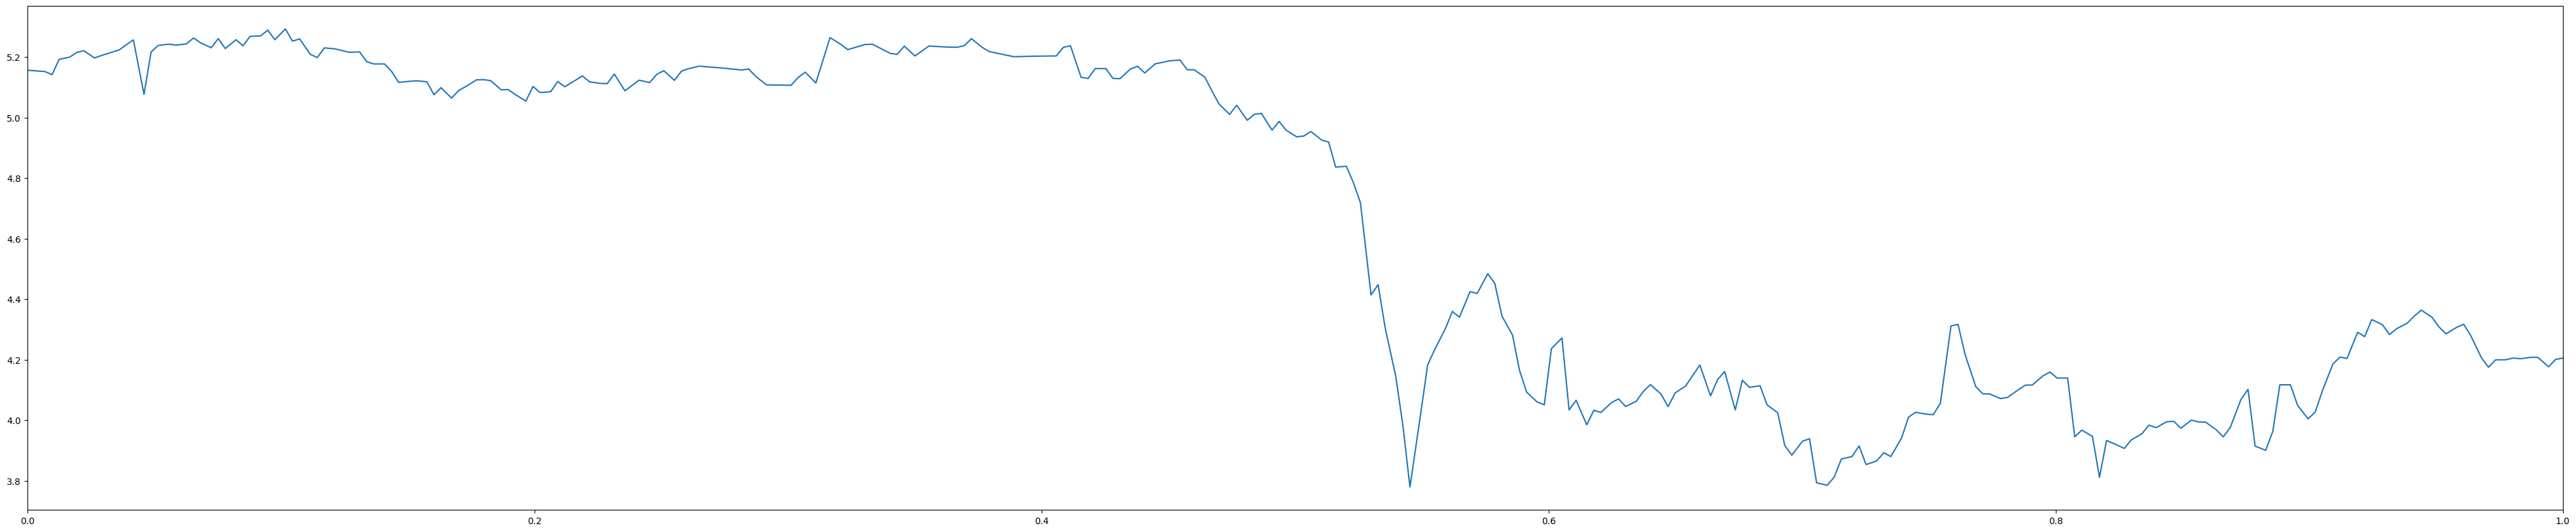

In [4]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Y)
plt.margins(x=0);

In [257]:
def polynomial_features(x: torch.tensor, max_pow: int) -> torch.tensor:
    """
    This function takes a tensor of shape (-1, 1) and returns a new tensor 
    where each column corresponds to the input features raised to the 
    powers from 1 to 'max_pow'.
    """
    assert x.dim() == 2 and x.shape[-1] == 1, f"Input tensor must be of shape (-1, 1). Got {tuple(x.shape)} instead."
    powers = torch.arange(1, max_pow + 1)
    return torch.pow(x, powers)


class MLP(nn.Module):

    def __init__(self, ipt_size: int, hidden_ns: list) -> None:
        super().__init__()
        
        layers = [nn.Linear(ipt_size, hidden_ns[0]), nn.GELU()]  # input layer + relu
        for n0, n1 in zip(hidden_ns[:-1], hidden_ns[1:]):  # hidden layers + relus
            layers.extend([nn.Linear(n0, n1), nn.GELU()])
        layers.append(nn.Linear(hidden_ns[-1], 1))  # output layer

        self.layers = nn.Sequential(*layers)  # stack layers
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layers(x)

In [268]:
input_size = 3
hidden_neurons = [100, 200, 100]
model = MLP(input_size, hidden_neurons)
for layer in model.children():
    print(layer)

Sequential(
  (0): Linear(in_features=3, out_features=100, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=100, out_features=200, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=100, out_features=1, bias=True)
)


In [270]:
# [288] -> [288, 1]
Xn = Xn.view(-1, 1)
Y = Y.view(-1, 1)
# [288, 1] -> [288, num_polynomials]
Xtr = polynomial_features(Xn, input_size)
Xtr.shape

torch.Size([288, 3])

In [275]:
mse_loss = nn.MSELoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_iters = 1000
for i in range(num_iters):
    optimizer.zero_grad(set_to_none=True)
    preds = model(Xtr)
    loss = mse_loss(preds, Y)
    print(loss)
    loss.backward()
    optimizer.step()

tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.2876, grad_fn=<MseLossBackward0>)
tensor(0.0288, grad_fn=<MseLossBackward0>)
tensor(0.0763, grad_fn=<MseLossBackward0>)
tensor(0.1716, grad_fn=<MseLossBackward0>)
tensor(0.1123, grad_fn=<MseLossBackward0>)
tensor(0.0289, grad_fn=<MseLossBackward0>)
tensor(0.0153, grad_fn=<MseLossBackward0>)
tensor(0.0578, grad_fn=<MseLossBackward0>)
tensor(0.0888, grad_fn=<MseLossBackward0>)
tensor(0.0754, grad_fn=<MseLossBackward0>)
tensor(0.0374, grad_fn=<MseLossBackward0>)
tensor(0.0118, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(0.0411, grad_fn=<MseLossBackward0>)
tensor(0.0522, grad_fn=<MseLossBackward0>)
tensor(0.0400, grad_fn=<MseLossBackward0>)
tensor(0.0194, grad_fn=<MseLossBackward0>)
tensor(0.0100, grad_fn=<MseLossBackward0>)
tensor(0.0169, grad_fn=<MseLossBackward0>)
tensor(0.0290, grad_fn=<MseLossBackward0>)
tensor(0.0329, grad_fn=<MseLossBackward0>)
tensor(0.0253, grad_fn=<MseLossBackward0>)
tensor(0.01

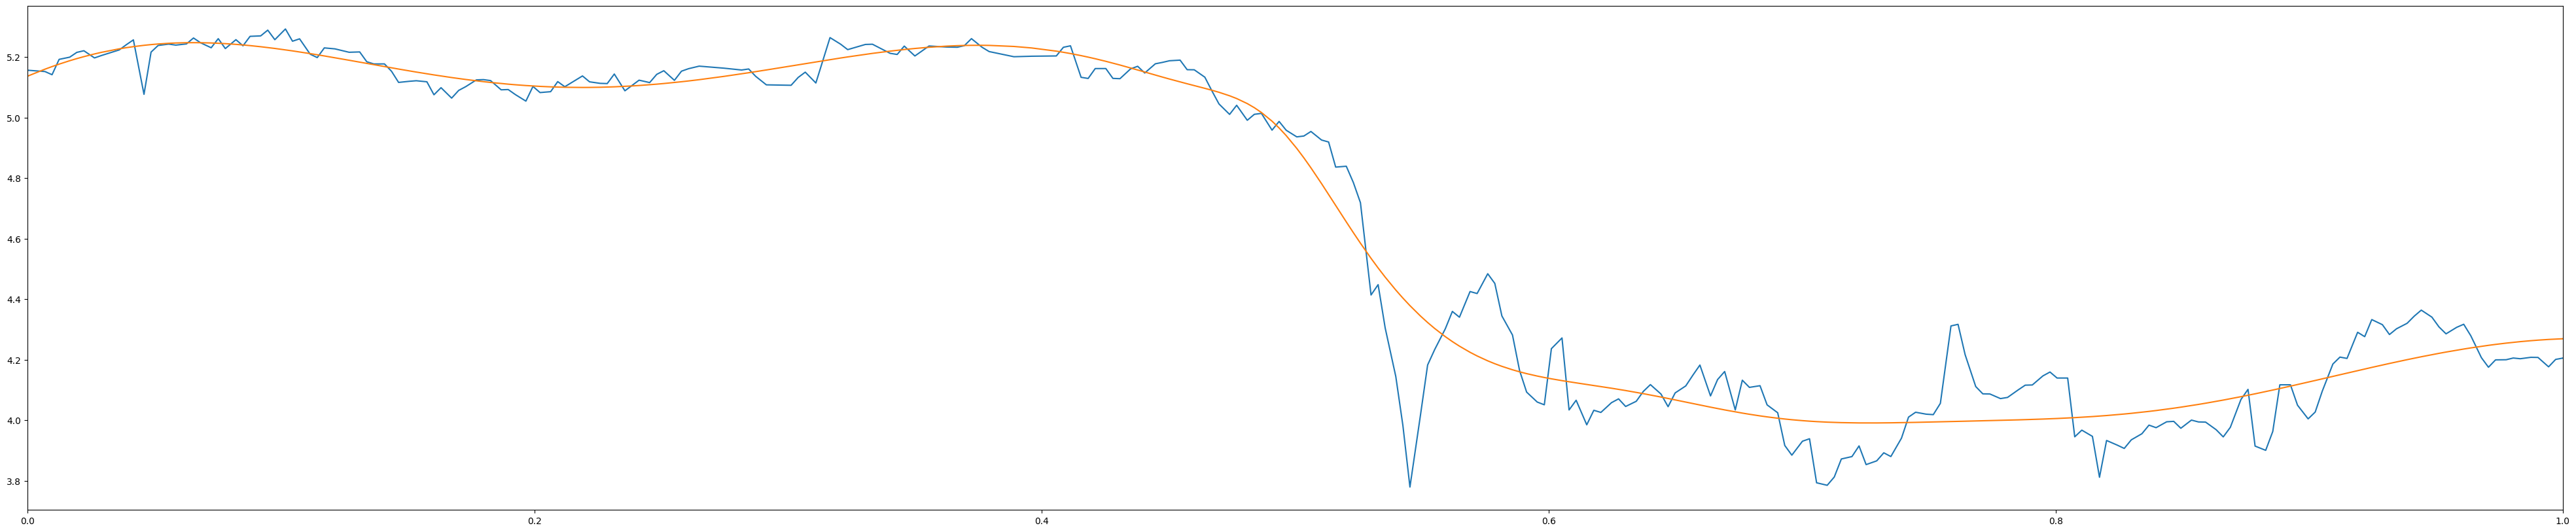

In [276]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Y)
# Approximation
plt.plot(Xn, preds.detach())
plt.margins(x=0);

In [346]:
# Turn on tracking
Xn.requires_grad_(True)

Xtr1 = polynomial_features(Xn, input_size)
out = model(Xtr1)
sumout = out.sum()
sumout.backward()
# Gradients with respect to Xn
grads = Xn.grad

# Clear gradients, turn off tracking
Xn.grad = None
Xn.requires_grad_(False);

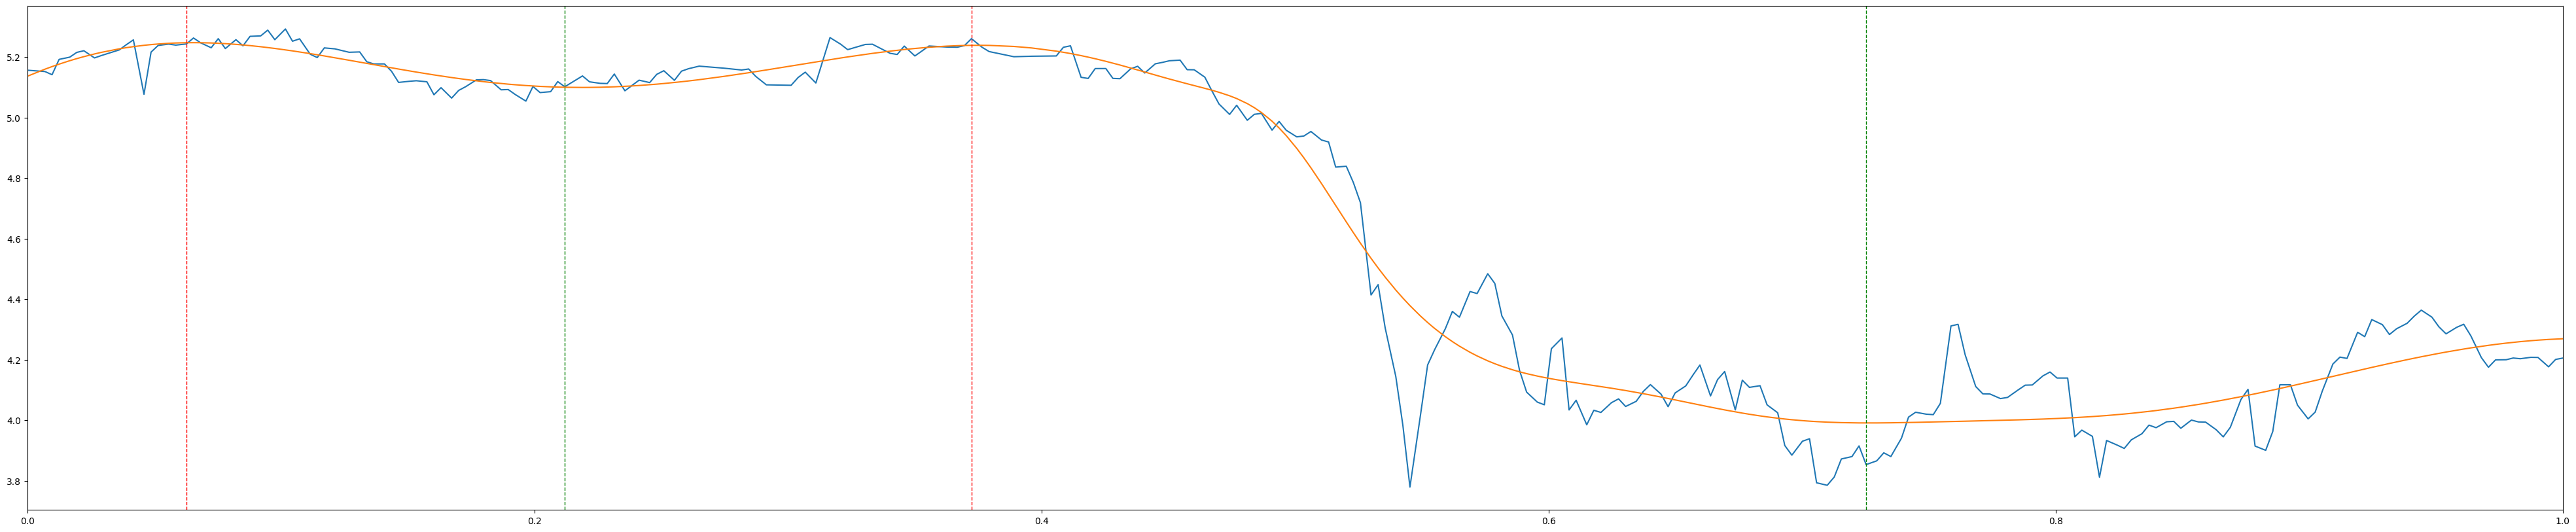

In [366]:
fig, ax = plt.subplots(figsize=(50, 10))

ax.plot(Xn, Y)
ax.plot(Xn, preds.detach())

extremums = []
for i, (prev, next) in enumerate(zip(grads, grads[1:])):
    if prev <= 0 and next > 0:
        ax.axvline(x=Xn[i], color='green', linestyle='--', linewidth=1)
        extremums.append(i)
    elif prev > 0 and next <= 0:
        ax.axvline(x=Xn[i], color='red', linestyle='--', linewidth=1)
        extremums.append(i)

ax.margins(x=0);

In [367]:
extremums

[17, 62, 100, 203]

In [383]:
for i, (prev, next) in enumerate(zip(extremums, extremums[1:])):
    print(f"{i}: {(Y[next] / Y[prev] - 1).item():+.10f} %")

0: -0.0269726515 %
1: +0.0311502218 %
2: -0.2675557733 %
